In [ ]:
import pandas as pd
import torch
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
import datetime
from google.colab import drive
drive.mount('/content/drive')
!pip install -q xlrd

Mounted at /content/drive


# **I. Data Preprocessing**

***1. This part Play the Responsibility: preprocess the y value and numpy array X of data by Construct several function corresponding to each data type.***

In [ ]:
# read the data expected to the pandas dataframe
df1 = pd.read_csv('/content/drive/My Drive/Data/EPA_merged_2019-2021.csv').drop(columns = ['co', 'no2', 'pm10'])

# This function resolve the problem of unsynchronized data format in df1 'time' landmark
def timeConvert(stringTime):
  if not stringTime.startswith("2021") and not stringTime.startswith("2020"):
    return datetime.datetime.strptime(stringTime, '%d/%m/%Y %H:%M')
  return datetime.datetime.strptime(stringTime, '%Y-%m-%d %H:%M:%S')

df1['time'] = df1['time'].apply(lambda x : timeConvert(x))
df1['Year'] = pd.DatetimeIndex(df1['time']).year
df1['Month'] = pd.DatetimeIndex(df1['time']).month
# Try calculating average of weight groupby Month. But it's necessary to determine that it's not just groupby Month column, it also depend on Year .
df1['Year-Month'] = df1.apply(lambda x: '%s-%s' % (x['Year'], x['Month']), axis = 1)
Month_Series_AVE = df1.groupby(['name', 'Year-Month']).mean()

In [ ]:
print(Month_Series_AVE)

                         pm25      lat       lon  Year  Month
name    Year-Month                                           
ankhanh 2020-10      8.356183  21.0024  105.7181  2020     10
        2020-11     12.632778  21.0024  105.7181  2020     11
        2020-12     26.127688  21.0024  105.7181  2020     12
        2020-5      21.984010  21.0024  105.7181  2020      5
        2020-6      12.413769  21.0024  105.7181  2020      6
...                       ...      ...       ...   ...    ...
xuanmai 2021-2      55.598653  20.8994  105.5773  2021      2
        2021-3      50.795380  20.8994  105.5773  2021      3
        2021-4      40.802364  20.8994  105.5773  2021      4
        2021-5      31.248925  20.8994  105.5773  2021      5
        2021-6      39.545263  20.8994  105.5773  2021      6

[620 rows x 5 columns]


In [ ]:
# Data in full packet without split to train, validation.
Xfull = []
Yfull = []

In [ ]:
from osgeo import gdal
from osgeo import ogr
import matplotlib.pyplot as plt

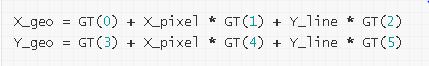

In [ ]:
!pip install pyproj
from pyproj import Proj
prj = Proj('+proj=utm +zone=48 +ellps=WGS84 +datum=WGS84 +units=m +no_defs', preserve_units=False, errcheck=True)

     |████████████████████████████████| 6.3 MB 13.7 MB/s 


In [ ]:
# This function get the value around point corresponding to particular datatype eg: population, land cover, traffic tile, ...
def getValueAroundPoint(img_data, geotransform, lat, lon, width, nodata, dtype):
    result = np.array((), dtype=np.float32)   
    offset_x = (lat - geotransform[3])/geotransform[5]
    offset_y = (lon - geotransform[0])/geotransform[1]
    evenWidth = ((width%2)==0)
    radius = (width-1)/2.0
    maxOffset = int(np.floor(radius))
    if evenWidth:
        maxOffset = maxOffset + 1
        center_offset_x = np.ceil(offset_x)
        center_offset_y = np.floor(offset_y)
    elif not evenWidth:
        center_offset_x = int(np.floor(offset_x) + 0.5)
        center_offset_y = int(np.floor(offset_y) + 0.5)
    # print(center_offset_x)
    # print(center_offset_y)
    minOffset = int(np.floor(radius) * -1)
    for y in range(minOffset, maxOffset + 1):
        for x in range(minOffset, maxOffset + 1):
            double_x = float(x)
            double_y = float(y)
            real_x = int(center_offset_x - double_x)
            real_y = int(center_offset_y + double_y)
            if evenWidth:
                double_x = double_x - 0.5 
                double_y = double_y - 0.5  
                real_x = int(center_offset_x - (double_x + 0.5))
                real_y = int(center_offset_y + (double_y + 0.5))
            distance = np.sqrt((double_x * double_x) + (double_y * double_y))
            if (0 < real_x < img_data.shape[0]) and (0 < real_y < img_data.shape[1]):
                if (distance <= radius):
                    if (img_data[real_x][real_y] != nodata):
                        if (not np.isnan(img_data[real_x][real_y])):
                            result = np.append(result, img_data[real_x][real_y])
    # print(result.size)
    if (result.size > 0):
        if dtype == 'pop' or dtype == 'traffic' or dtype == 'distribution':
            return np.array([result.mean()], dtype=np.float32)
        elif dtype == 'lc':
            count_1 = np.count_nonzero(result == 1)
            count_2 = np.count_nonzero(result == 2)
            count_3 = np.count_nonzero(result == 3)
            count_4 = np.count_nonzero(result == 4)
            count_5 = np.count_nonzero(result == 5)
            count_6 = np.count_nonzero(result == 6)
            count_7 = np.count_nonzero(result == 7)
            return np.array([count_1, count_2, count_3, count_4, count_5, count_6, count_7], dtype=np.float32)
    else:
        if dtype == 'pop' or dtype == 'traffic' or dtype == 'distribution':
            return np.array([0], dtype=np.float32)
        elif dtype == 'lc':
            return np.array([0, 0, 0, 0, 0, 0, 0], dtype=np.float32)

In [ ]:
# Get traffic tile in practical map.
def getTrafficTile(lat, lon, width):
  path1 = "/content/drive/My Drive/Data/average_average_30m.tif"
  path2 = "/content/drive/My Drive/Data/average_normal_30m.tif"
  path3 = "/content/drive/My Drive/Data/average_rush_30m.tif"
  ds1 = gdal.Open(path1)
  ds1_band = ds1.GetRasterBand(1)
  nodataval1 = ds1_band.GetNoDataValue()
  gt1 = ds1.GetGeoTransform()
  ds1_arr = ds1.ReadAsArray().astype(np.float64)

  ds2 = gdal.Open(path2)
  ds2_band = ds2.GetRasterBand(1)
  nodataval2 = ds2_band.GetNoDataValue()
  gt2 = ds2.GetGeoTransform()
  ds2_arr = ds2.ReadAsArray().astype(np.float64)

  ds3 = gdal.Open(path3)
  ds3_band = ds3.GetRasterBand(1)
  nodataval3 = ds3_band.GetNoDataValue()
  gt3 = ds3.GetGeoTransform()
  ds3_arr = ds3.ReadAsArray().astype(np.float64)
  avg = getValueAroundPoint(ds1_arr, gt1, prj(lon, lat)[1], prj(lon, lat)[0], width/gt1[1], nodataval1, 'traffic')
  normal = getValueAroundPoint(ds2_arr, gt2, prj(lon, lat)[1], prj(lon, lat)[0], width/gt2[1], nodataval2, 'traffic')
  rush = getValueAroundPoint(ds3_arr, gt3, prj(lon, lat)[1], prj(lon, lat)[0], width/gt3[1], nodataval3, 'traffic')
  return np.array([avg, normal, rush])

In [ ]:
# Get raw data PM25 in practical map.
def getRawPM25(lat, lon, year, month, width):
  path = "/content/drive/My Drive/Data/" + str(year) + "/PM25_" + str(year)

  if month < 10: path = path + '0' + str(month) + '01_hanoi.tif'
  else: path = path + str(month) + '01_hanoi.tif'

  ds = gdal.Open(path)
  ds_band = ds.GetRasterBand(1)
  nodataval = ds_band.GetNoDataValue()
  ds_arr = ds.ReadAsArray().astype(np.float64)
  gt = ds.GetGeoTransform()
  return getValueAroundPoint(ds_arr, gt, prj(lon, lat)[1], prj(lon, lat)[0], width/gt[1], nodataval, 'distribution')

In [ ]:
# Get Population density through year statistical.
def getPopDensity(lat, lon, year, width):
  path = "/content/drive/My Drive/Data/hanoi_pd_" + str(year) + "_30m_Unadj.tif"
  ds = gdal.Open(path)
  ds_band = ds.GetRasterBand(1)
  nodataval = ds_band.GetNoDataValue()
  ds_arr = ds.ReadAsArray().astype(np.float64)
  gt = ds.GetGeoTransform()
  return getValueAroundPoint(ds_arr, gt, prj(lon, lat)[1], prj(lon, lat)[0], width/gt[1], nodataval, 'pop')

In [ ]:
# Get Land Cover in Common
def getLandCover(lat, lon, width):
  path = "/content/drive/My Drive/Data/lc_2017.tif"
  ds = gdal.Open(path)
  ds_band = ds.GetRasterBand(1)
  nodataval = ds_band.GetNoDataValue()
  ds_arr = ds.ReadAsArray().astype(np.float64)
  gt = ds.GetGeoTransform()
  return getValueAroundPoint(ds_arr, gt, prj(lon, lat)[1], prj(lon, lat)[0], width/gt[1], nodataval, 'lc')

In [ ]:
# Get road density statistical
def getRoadDensity(lat, lon, width):
  path = "/content/drive/My Drive/Data/road_density_HN_30m_Clipped.tif"
  ds = gdal.Open(path)
  ds_band = ds.GetRasterBand(1)
  nodataval = ds_band.GetNoDataValue()
  ds_arr = ds.ReadAsArray().astype(np.float64)
  gt = ds.GetGeoTransform()
  return getValueAroundPoint(ds_arr, gt, prj(lon, lat)[1], prj(lon, lat)[0], width/gt[1], nodataval, 'traffic')

In [ ]:
# Get VVNB feature
df2 = pd.read_csv('/content/drive/My Drive/Data/VVNB_2019-2021_mean_by_month.csv')
def getVVNB(year, month):
  strquery = "year == '" + str(year) + "' and month == '" + str(year) + "-"
  if month < 10: strquery = strquery + "0" + str(month) + "'"
  else: strquery = strquery + str(month) + "'"
  altm = df2.query(strquery).iloc[0, 2]
  temp = df2.query(strquery).iloc[0, 3]
  hud = df2.query(strquery).iloc[0, 4]
  wdir = df2.query(strquery).iloc[0, 5]
  wspd = df2.query(strquery).iloc[0, 6]
  vis = df2.query(strquery).iloc[0, 7]
  return np.array([altm, temp, hud, wdir, wspd, vis])

***2. This part is beginning extract data to store into numpy array***

In [ ]:
# Big Step to store data
# Constantly Width Hyper Parameter: 
width = 1000
for i in range(0, len(Month_Series_AVE['lat'])):
  if Month_Series_AVE.iloc[i, 3] == 2021: continue
  # One datapoint
  # label had been added first
  Yfull.append(np.array([round(Month_Series_AVE.iloc[i, 0], 4)]))
  lat = round(Month_Series_AVE.iloc[i, 1], 4)
  lon = round(Month_Series_AVE.iloc[i, 2], 4)
  year = Month_Series_AVE.iloc[i, 3]
  month = Month_Series_AVE.iloc[i, 4]
  # inject rawPm25
  X = getRawPM25(lat, lon, year, month, width).reshape(1, -1)
  # inject traffic tile
  X = np.concatenate((X, getTrafficTile(lat, lon, width).reshape(1, -1)), axis = 1)
  # inject land cover
  X = np.concatenate((X, getLandCover(lat, lon, width).reshape(1, -1)), axis = 1)
  # inject road density
  X = np.concatenate((X, getRoadDensity(lat, lon, width).reshape(1, -1)), axis = 1)
  # inject population density
  X = np.concatenate((X, getPopDensity(lat, lon, year, width).reshape(1, -1)), axis = 1)
  # inject VVNB feature
  X = np.concatenate((X, getVVNB(year, month).reshape(1, -1)), axis = 1)
  Xfull.append(X.reshape(19))

# **II. Building the Model**

In [ ]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.utils.data import Subset
from sklearn.model_selection import train_test_split
import torchvision

from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
# tensorboard evaluate support
torch.autograd.set_detect_anomaly(True)

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
!pip install pytorch_lightning

In [ ]:
import pytorch_lightning as pl
import math

***1. Prepare dataset and call it to tensor.***

In [ ]:
tensor_x = torch.Tensor(Xfull)
tensor_y = torch.Tensor(Yfull)
tensor_x.unsqueeze(1)
tensor_x.unsqueeze(1)
# normalize input
tensor_x_mean = torch.mean(tensor_x)
tensor_x_std = torch.std(tensor_x)
tensor_x = tensor_x - tensor_x_mean
tensor_x = tensor_x / tensor_x_std

# normalize target
tensor_y_mean = torch.mean(tensor_y)
tensor_y_std = torch.std(tensor_y)
tensor_y_norm = tensor_y - tensor_y_mean
tensor_y_norm = tensor_y_norm / tensor_y_std

# tensor_y = tensor_y.view((len(Yfull), 1, 1))
my_dataset = TensorDataset(tensor_x, tensor_y_norm)
# my_dataloader = DataLoader(my_dataset, batch_size = 8)
# Split datasets into 25% validation and 75% train with Hyper parameter batch size = 8.
train_idx, val_idx = train_test_split(list(range(len(my_dataset))), test_size=0.25)
datasets = {}
datasets['train'] = Subset(my_dataset, train_idx)
datasets['validate'] = Subset(my_dataset, val_idx)
dataloaders = {x:DataLoader(datasets[x], 4, shuffle=False, num_workers= 1) for x in ['train','validate']}

***2. Construct the Neural Network Model with 2 hiden layer and 1 output in last layer***

*Defining The Loss function Mean Square Error, Optimizer update model parameter using Stochastic Gradient Descent with Backpropagation.*

In [ ]:
pl.log_every_n_steps = 2

In [ ]:
class NeuralNet(pl.LightningModule):
  
  def __init__(self):
    super().__init__()
    self.layers = nn.Sequential(
      nn.Linear(19, 1950, bias = True),
      nn.LeakyReLU(),
      nn.Linear(1950, 950, bias = True),
      nn.ReLU(),
      nn.Linear(950, 1, bias = True),
    )
    self.ce = torch.nn.MSELoss()
    
  def forward(self, x):
    return self.layers(x)
  
  def training_step(self, batch, batch_idx):
    x, y = batch
    x = x.view(x.size(0), -1)
    y_hat = self.layers(x)
    # print(y_hat)
    # print(y)
    loss = self.ce(y_hat, y)
    self.log('train_loss', loss)
    return loss
  
  def configure_optimizers(self):
    optimizer = torch.optim.SGD(model.parameters(), lr=0.0001, momentum = 0.9)
    return optimizer

model = NeuralNet()
# As Long Using Stochastic Gradient Descent to optimizing model params
# Hyper Parameter learning rate = 0.001 and momentum = 0.9 to pass the local Extreme point. Need to statistical in more time training.
# Using Mean Square Error, aka L2norm distance.
training_loader = torch.utils.data.DataLoader(datasets['train'], batch_size=4, shuffle=True, num_workers=1, pin_memory=True)
validation_loader = torch.utils.data.DataLoader(datasets['validate'], batch_size=4, shuffle=True, num_workers=1, pin_memory=True)
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.0001, momentum = 0.9)

In [ ]:
pl.seed_everything(42)
trainer = pl.Trainer(gpus=0, deterministic=True, max_epochs=20)
trainer.fit(model, training_loader)

***3. Start Training and Evaluating Model***

*Step by Step What the forward and backward affected the model parameter*

In [ ]:
def train_one_epoch(epoch_index, tb_writer):
    running_loss = 0.
    last_loss = 0.
    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    for i, data in enumerate(training_loader):
        inputs, target = data
        
        # Zero your gradients for every batch!
        optimizer.zero_grad()
        # Make predictions for this batch
        outputs = model(inputs)
        loss = loss_fn(outputs, target)
        # Backpropagation
        loss.backward(retain_graph=True)
        # Adjust learning weights
        optimizer.step()
        # Gather data and report
        running_loss += loss.item()
        last_loss = running_loss/4  # loss per batch
        print('  batch {} loss: {}'.format(i + 1, last_loss))
        tb_x = epoch_index * len(training_loader) + i + 1
        tb_writer.add_scalar('Loss/train', last_loss, tb_x)
        running_loss = 0.

    return last_loss

*Training and Evaluate in 20 epochs*

In [ ]:
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))
epoch_number = 0

EPOCHS = 30

best_vloss = 1_000_000.

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    avg_loss = train_one_epoch(epoch_number, writer)

    # We don't need gradients on to do reporting
    model.train(False)

    running_vloss = 0.0
    for i, vdata in enumerate(validation_loader):
        vinputs, vlabels = vdata
        voutputs = model(vinputs)
        vloss = loss_fn(voutputs, vlabels)
        running_vloss += vloss

    avg_vloss = running_vloss / (i + 1)
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

    # Log the running loss averaged per batch
    # for both training and validation
    writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : avg_loss, 'Validation' : avg_vloss },
                    epoch_number + 1)
    writer.flush()

    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = 'model_{}_{}'.format(timestamp, epoch_number)
        torch.save(model.state_dict(), model_path)

    epoch_number += 1

EPOCH 1:
  batch 1 loss: 0.5040348172187805
  batch 2 loss: 0.20588332414627075
  batch 3 loss: 0.1448315531015396
  batch 4 loss: 0.1543264389038086
  batch 5 loss: 0.32019567489624023
  batch 6 loss: 0.6655056476593018
  batch 7 loss: 0.20674821734428406
  batch 8 loss: 0.23021455109119415
  batch 9 loss: 0.28883984684944153
  batch 10 loss: 0.5924987196922302
  batch 11 loss: 0.5358014702796936
  batch 12 loss: 0.24778775870800018
  batch 13 loss: 0.17660938203334808
  batch 14 loss: 0.1408720314502716
  batch 15 loss: 0.4146944582462311
  batch 16 loss: 0.24226036667823792
  batch 17 loss: 0.38123422861099243
  batch 18 loss: 0.14072054624557495
  batch 19 loss: 0.3346032500267029
  batch 20 loss: 0.17846998572349548
  batch 21 loss: 0.25450974702835083
  batch 22 loss: 0.06074845418334007
  batch 23 loss: 0.17443467676639557
  batch 24 loss: 0.24581021070480347
  batch 25 loss: 0.6123690009117126
  batch 26 loss: 0.4004790484905243
  batch 27 loss: 0.5497849583625793
  batch 28 lo

# **III. Test Model with particular Input constructing**

In [ ]:
# Process Test Sample data
def testDatapoint(lat, lon, year, month, width = 1000):
  # One datapoint
  # inject rawPm25
  X = getRawPM25(lat, lon, year, month, width).reshape(1, -1)
  # inject traffic tile
  X = np.concatenate((X, getTrafficTile(lat, lon, width).reshape(1, -1)), axis = 1)
  # inject land cover
  X = np.concatenate((X, getLandCover(lat, lon, width).reshape(1, -1)), axis = 1)
  # inject road density
  X = np.concatenate((X, getRoadDensity(lat, lon, width).reshape(1, -1)), axis = 1)
  # inject population density
  X = np.concatenate((X, getPopDensity(lat, lon, year, width).reshape(1, -1)), axis = 1)
  # inject VVNB feature
  X = np.concatenate((X, getVVNB(year, month).reshape(1, -1)), axis = 1)
  return X.reshape(19)

def getTruePM25(lat, lon, year, month):
  strquery = "Year == " + str(year) + " and Month == " + str(month)
  strquery = strquery + " and lat == " + str(lat) + " and lon == " + str(lon)
  print(Month_Series_AVE.query(strquery))
  return Month_Series_AVE.query(strquery).iloc[0, 0]


In [ ]:
num = 6
print(Month_Series_AVE.iloc[num, 1], Month_Series_AVE.iloc[num, 2], Month_Series_AVE.iloc[num, 3], Month_Series_AVE.iloc[num, 4])
with torch.no_grad():
    x_in = []
    x_in.append(testDatapoint(Month_Series_AVE.iloc[num, 1], Month_Series_AVE.iloc[num, 2], Month_Series_AVE.iloc[num, 3], Month_Series_AVE.iloc[num, 4]))
    x = torch.Tensor(x_in)
    x.unsqueeze(1)
    ypred = model((x - tensor_x_mean)/tensor_x_std)
    # unnormlalize prediction
    ypred = ypred * tensor_y_std
    ypred = ypred + tensor_y_mean

21.002399999999778 105.71809999999863 2020 8


In [ ]:
print(ypred.item())
print(getTruePM25(Month_Series_AVE.iloc[num, 1], Month_Series_AVE.iloc[num, 2], Month_Series_AVE.iloc[num, 3], Month_Series_AVE.iloc[num, 4]))

23.054718017578125
                         pm25      lat       lon  Year  Month
name    Year-Month                                           
ankhanh 2020-8      12.711051  21.0024  105.7181  2020      8
12.711051212938006


In [ ]:
saved_model = GarmentClassifier()
saved_model.load_state_dict(torch.load(PATH))